<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__Problem Statement__
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from tqdm import tqdm
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6

from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS
from os import path
import pickle
import image

<h1>3. Exploratory Data Analysis </h1>

In [28]:
df = pd.read_csv("train.csv")
print("Number of data points:",df.shape[0])
df.head()

Number of data points: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.1 Distribution of data points among output classes</h3><br>
    - Number of duplicate(smilar) and non-duplicate(non similar) questions

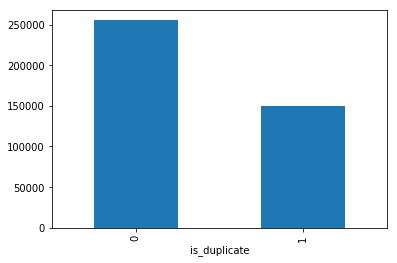

In [30]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [31]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2 Number of unique questions </h3>

In [32]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()
q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



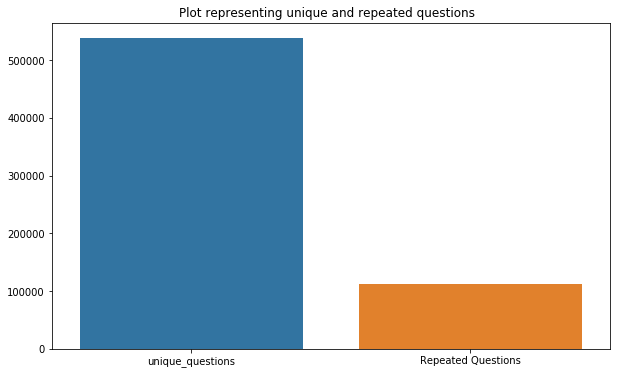

In [33]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.3 Checking for Duplicates </h3>

In [34]:
#checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



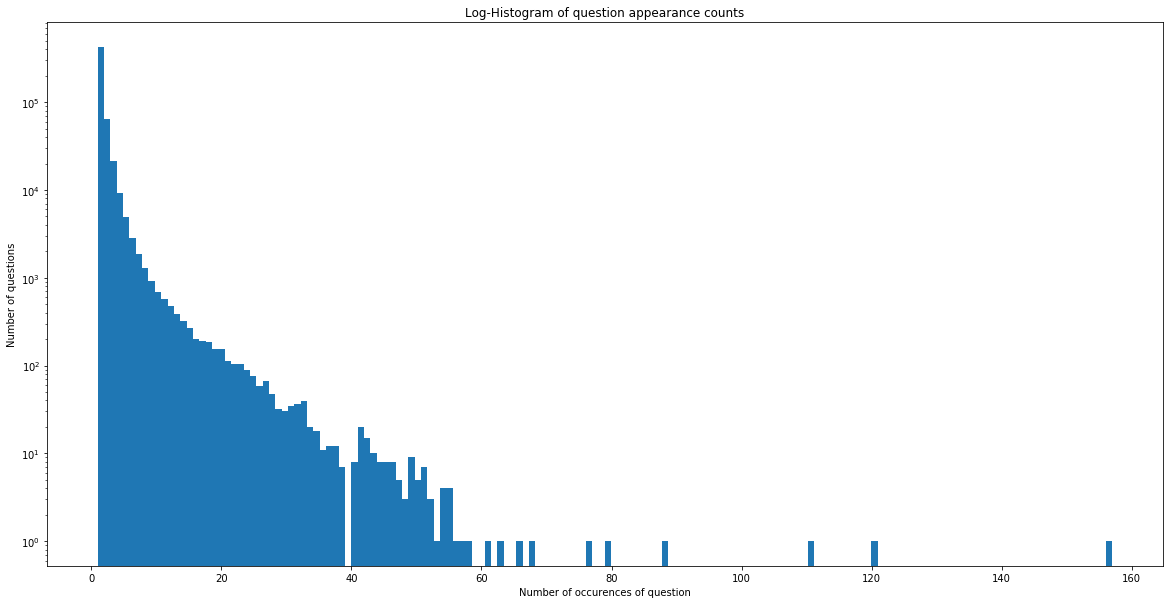

In [35]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.5 Checking for NULL values </h3>

In [36]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [37]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [13]:
# Sampling random 100k points
# df = df.sample(100000)

<h2> 4 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [38]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### 5 EDA: Advanced Feature Extraction.

In [2]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [17]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,151602,22259,182436,How can I get my lost iPhone IMEI number back?,"How do I recover my lost iPhone 4s, using the ...",1,1,1,46,58,10,12,6.0,22.0,0.272727,2,0
1,84756,143254,143255,What is the meaning of sign?,What is the meaning of these signs?,0,1,1,28,35,6,7,5.0,13.0,0.384615,2,0
2,165372,140487,97264,What does Trump's victory mean for India?,How will Trump's victory effect India?,1,4,1,41,38,7,6,3.0,13.0,0.230769,5,3
3,80229,136433,18902,Do you suspect your spouse if he/she is cheating?,Do you suspect your spouse is cheating on you?,1,2,2,49,46,9,9,6.0,18.0,0.333333,4,0
4,113713,185767,185768,What is the most beautiful tourist destination...,What are the most beautiful and untouched tour...,1,1,1,67,79,10,11,7.0,20.0,0.350000,2,0


<h4>Preprocessing of Text </h4>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [21]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

# When stopwords are not found try:python3 -m nltk.downloader stopwords
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [25]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [25]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h2> 3.6 Featurizing text data with tfidf </h2>

In [7]:
# avoid decoding problems
df = pd.read_csv("train.csv")
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [8]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [9]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)[:100000]
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)[:100000]
# Dataset = df1+df2+df['question1'][:100000]+df['question2'][:100000]
AddedFeatureDF = pd.concat([df1,df2], axis=1)
TextDatasetDF = pd.DataFrame(
    {'question1': df['question1'][:100000],
     'question2': df['question2'][:100000]
    })
Dataset = pd.concat([AddedFeatureDF,TextDatasetDF],axis = 1)

In [10]:
# cols = list(Dataset.columns)
# for i in cols:
#     Dataset[i] = Dataset[i].apply(pd.to_numeric)
#     print(i)

In [11]:
Dataset.drop(['id'],axis=1,inplace=True)

In [12]:
Dataset.head(3)

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,question1,question2
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,...,57,14,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,...,88,8,13,4.0,20.0,0.200000,5,3,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,...,59,14,10,4.0,24.0,0.166667,2,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...


In [13]:
X = Dataset.iloc[:,1:].values
Y = Dataset.is_duplicate.values

# Splitting into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)

# Train set
X_trainText_q1 = np.array(X_train[:,-2:-1])
X_trainText_q1 = X_trainText_q1.reshape(X_trainText_q1.shape[0],)

X_trainText_q2 = np.array(X_train[:,-1:])
X_trainText_q2 = X_trainText_q2.reshape(X_trainText_q2.shape[0],)

# CV set
X_cvText_q1 = np.array(X_cv[:,-2:-1])
X_cvText_q1 = X_cvText_q1.reshape(X_cvText_q1.shape[0],)

X_cvText_q2 = np.array(X_cv[:,-1:])
X_cvText_q2 = X_cvText_q2.reshape(X_cvText_q2.shape[0],)

# Test set
X_testTest_q1 = np.array(X_test[:,-2:-1])
X_testTest_q1 = X_testTest_q1.reshape(X_testTest_q1.shape[0],)

X_testTest_q2 = np.array(X_test[:,-1])
X_testTest_q2 = X_testTest_q2.reshape(X_testTest_q2.shape[0],)

In [14]:
# Vectorizing question set1
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=500)
vectorizer.fit(X_trainText_q1)

X_train_tfidf_q1 = vectorizer.transform(X_trainText_q1)
print("Train Data Size: ",X_train_tfidf_q1.shape)

X_cv_tfidf_q1 = vectorizer.transform(X_cvText_q1)
print("CV Data Size: ",X_cv_tfidf_q1.shape)

X_test_tfidf_q1 = vectorizer.transform(X_testTest_q1)
print("Test Data Size:  ",X_test_tfidf_q1.shape)

Train Data Size:  (44890, 500)
CV Data Size:  (22110, 500)
Test Data Size:   (33000, 500)


In [15]:
# Vectorizing question set2
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=500)
vectorizer.fit(X_trainText_q2)

X_train_tfidf_q2 = vectorizer.transform(X_trainText_q2)
print("Train Data Size: ",X_train_tfidf_q2.shape)

X_cv_tfidf_q2 = vectorizer.transform(X_cvText_q2)
print("CV Data Size: ",X_cv_tfidf_q2.shape)

X_test_tfidf_q2 = vectorizer.transform(X_testTest_q2)
print("Test Data Size:  ",X_test_tfidf_q2.shape)

Train Data Size:  (44890, 500)
CV Data Size:  (22110, 500)
Test Data Size:   (33000, 500)


In [16]:
# Combining word vector with advance feature for training set
q1_Vect_df = pd.DataFrame(X_train_tfidf_q1.toarray())
q2_Vect_df = pd.DataFrame(X_train_tfidf_q2.toarray())
q3_AdvFeature = pd.DataFrame(X_train[:,:-2])
TrainData = pd.concat([q3_AdvFeature,q1_Vect_df,q2_Vect_df],axis = 1)

In [17]:
TrainData.to_pickle("TrainDF")

In [18]:
# Combining word vector with advance feature for CV set
q1_Vect_df = pd.DataFrame(X_cv_tfidf_q1.toarray())
q2_Vect_df = pd.DataFrame(X_cv_tfidf_q2.toarray())
q3_AdvFeature = pd.DataFrame(X_cv[:,:-2])
CvData = pd.concat([q3_AdvFeature,q1_Vect_df,q2_Vect_df],axis = 1)

In [19]:
CvData.to_pickle("CvDF")

In [20]:
# Combining word vector with advance feature for test set
q1_Vect_df = pd.DataFrame(X_test_tfidf_q1.toarray())
q2_Vect_df = pd.DataFrame(X_test_tfidf_q2.toarray())
q3_AdvFeature = pd.DataFrame(X_test[:,:-2])
TestData = pd.concat([q3_AdvFeature,q1_Vect_df,q2_Vect_df],axis = 1)

In [21]:
TestData.to_pickle("TestDF")

In [22]:
Y_train = pd.DataFrame(
    {'Train': y_train,
    })
Y_Cv = pd.DataFrame(
    {'Train': y_cv,
    })
Y_test = pd.DataFrame(
    {'Test': y_test,
    })

In [23]:
Y_train.to_pickle("YTrain")
Y_Cv.to_pickle("YCv")
Y_test.to_pickle("YTest")

#### Loading Data

In [4]:
XTrain = pd.read_pickle('TrainDF')
# Standardising Train Data
scaler = preprocessing.StandardScaler().fit(XTrain) 
X_Train_Vec = scaler.transform(XTrain)

In [5]:
XCv = pd.read_pickle('CvDF')
# Standardising Train Data
scaler = preprocessing.StandardScaler().fit(XCv) 
X_Cv_Vec = scaler.transform(XCv)

In [6]:
# Standardising Test Data
XTest = np.array(pd.read_pickle('TestDF'))
X_Test_Vec = scaler.transform(XTest)

In [7]:
# Loading output
YTrain = pd.read_pickle('YTrain')
YCv = pd.read_pickle('YCv')
YTest  = pd.read_pickle('YTest')

In [15]:
# Save to file in the current working directory
def saveModel(fileName,model):
        with open(fileName, 'wb') as file:
            pickle.dump(model, file)

In [16]:
# Load from file
def getModel(pkl_filename):
    with open(pkl_filename, 'rb') as file:
        pickle_model = pickle.load(file)
    return pickle_model

# Applying Logistic Regression

In [9]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
 
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [10]:
log_error_array_cv=[]
log_error_array_train=[]

alpha = np.logspace(-4,4,9)
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_Train_Vec, YTrain)
    
    cal_model = CalibratedClassifierCV(clf, method="sigmoid")
    cal_model.fit(X_Train_Vec, YTrain)

    y_pred_cv = cal_model.predict_proba(X_Cv_Vec)
    logLoss_cv = log_loss(YCv, y_pred_cv, labels=clf.classes_, eps=1e-15)
    
    y_pred_train = cal_model.predict_proba(X_Train_Vec)
    logLoss_train = log_loss(YTrain, y_pred_train, labels=clf.classes_, eps=1e-15)
    
    
    log_error_array_cv.append(logLoss_cv)
    log_error_array_train.append(logLoss_train)
    print('For values of alpha = ', i, "The log loss is:", logLoss_cv)

 11%|█         | 1/9 [00:05<00:41,  5.21s/it]

For values of alpha =  0.0001 The log loss is: 0.4618569199218102


 22%|██▏       | 2/9 [00:10<00:35,  5.12s/it]

For values of alpha =  0.001 The log loss is: 0.45048164274606245


 33%|███▎      | 3/9 [00:14<00:30,  5.01s/it]

For values of alpha =  0.01 The log loss is: 0.41316377984180797


 44%|████▍     | 4/9 [00:19<00:24,  4.94s/it]

For values of alpha =  0.1 The log loss is: 0.4383966334698505


 56%|█████▌    | 5/9 [00:24<00:19,  4.89s/it]

For values of alpha =  1.0 The log loss is: 0.47664457796418286


 67%|██████▋   | 6/9 [00:29<00:14,  4.87s/it]

For values of alpha =  10.0 The log loss is: 0.5039377860633891


 78%|███████▊  | 7/9 [00:34<00:09,  4.86s/it]

For values of alpha =  100.0 The log loss is: 0.5108517943113103


 89%|████████▉ | 8/9 [00:38<00:04,  4.85s/it]

For values of alpha =  1000.0 The log loss is: 0.5116611267697572


100%|██████████| 9/9 [00:43<00:00,  4.91s/it]

For values of alpha =  10000.0 The log loss is: 0.5117332112922461


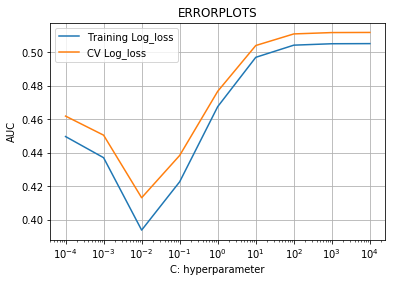

In [11]:
# Train vs CV AUC plot
plt.semilogx(alpha, log_error_array_train, label='Training Log_loss')
# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.semilogx(alpha, log_error_array_cv, label='CV Log_loss')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.grid()
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.556038177293996
For values of best alpha =  0.01 The test log loss is: 0.559677635426187


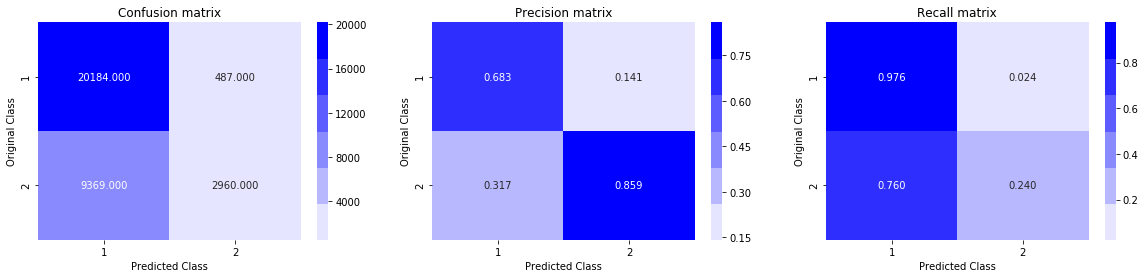

In [14]:
best_alpha = np.argmin(log_error_array_cv)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_Train_Vec, YTrain)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_Vec, YTrain)

predict_y = sig_clf.predict_proba(X_Train_Vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(YTrain, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_Test_Vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(YTest, predict_y, labels=clf.classes_, eps=1e-15))
# predicted_y =np.argmax(predict_y,axis=1)

# print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(YTest, sig_clf.predict(X_Test_Vec))

* Observation(s):
    - No overfitting as test and train log losses are nearly same.
    - Precision score for class 2 is better than the class 1.
    - Recall score for class 1 is very good, but Recall for class 2 is area of concern. 

# Applying Linear SVM

In [63]:
from tqdm import tqdm
log_error_array_cv=[]
log_error_array_train=[]
alpha = np.logspace(-4,4,9)
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_Train_Vec, YTrain)
    
    cal_model = CalibratedClassifierCV(clf, method="sigmoid")
    cal_model.fit(X_Train_Vec, YTrain)

    y_pred_cv = cal_model.predict_proba(X_Cv_Vec)
    logLoss_cv = log_loss(YCv, y_pred_cv, labels=clf.classes_, eps=1e-15)
    
    y_pred_train = cal_model.predict_proba(X_Train_Vec)
    logLoss_train = log_loss(YTrain, y_pred_train, labels=clf.classes_, eps=1e-15)
    
    
    log_error_array_cv.append(logLoss_cv)
    log_error_array_train.append(logLoss_train)
    print('For values of alpha = ', i, "The log loss is:", logLoss_cv)

 11%|█         | 1/9 [00:04<00:39,  4.98s/it]

For values of alpha =  0.0001 The log loss is: 0.46080965788288036


 22%|██▏       | 2/9 [00:09<00:34,  4.97s/it]

For values of alpha =  0.001 The log loss is: 0.45138800059346545


 33%|███▎      | 3/9 [00:14<00:29,  4.92s/it]

For values of alpha =  0.01 The log loss is: 0.422966972093795


 44%|████▍     | 4/9 [00:19<00:24,  4.98s/it]

For values of alpha =  0.1 The log loss is: 0.4300996591505402


 56%|█████▌    | 5/9 [00:25<00:20,  5.21s/it]

For values of alpha =  1.0 The log loss is: 0.45956466327401063


 67%|██████▋   | 6/9 [00:30<00:15,  5.26s/it]

For values of alpha =  10.0 The log loss is: 0.48833339908234874


 78%|███████▊  | 7/9 [00:37<00:11,  5.69s/it]

For values of alpha =  100.0 The log loss is: 0.5117253169332536


 89%|████████▉ | 8/9 [00:43<00:05,  5.78s/it]

For values of alpha =  1000.0 The log loss is: 0.5117268062166632


100%|██████████| 9/9 [00:49<00:00,  5.78s/it]

For values of alpha =  10000.0 The log loss is: 0.5117268062144549


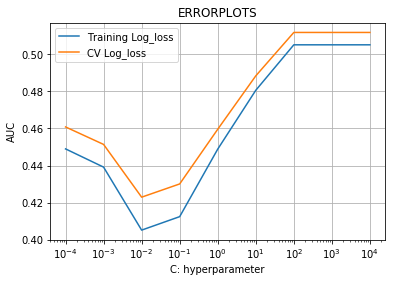

In [64]:
# Train vs CV AUC plot
plt.semilogx(alpha, log_error_array_train, label='Training Log_loss')
# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.semilogx(alpha, log_error_array_cv, label='CV Log_loss')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.grid()
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.556038177293996
For values of best alpha =  0.01 The test log loss is: 0.7076174755501318


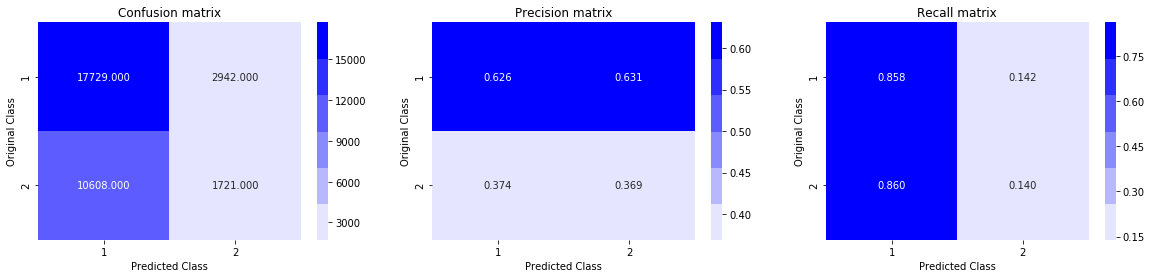

In [65]:
best_alpha = np.argmin(log_error_array_cv)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_Train_Vec, YTrain)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_Vec, YTrain)

predict_y = sig_clf.predict_proba(X_Train_Vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(YTrain, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_Test_Vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(YTest, predict_y, labels=clf.classes_, eps=1e-15))
# predicted_y =np.argmax(predict_y,axis=1)

# print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(YTest, sig_clf.predict(X_Test_Vec))

* Observation(s):
    - No overfitting as test and train log losses are nearly same.
    - Precision score for class 2 very low.
    - Recall score for class 1 is very good, but Recall for class 2 is area of concern. 

# Applying XGBoost

In [22]:
# import xgboost as xgb
# parameters = {'max_depth': 2,
#               'n_estimators': 4,
#               'objective': 'binary:logistic',
#               'eval_metric': 'logloss'}

# d_train = xgb.DMatrix(X_Train_Vec, label=YTrain)
# d_cv = xgb.DMatrix(X_Cv_Vec, label=YCv)

# watchlist = [(d_train, d_cv)]

# bst = xgb.train(params=parameters, dtrain=d_train, num_boost_round=300, evals = watchlist, early_stopping_rounds=20, verbose_eval=10)

In [ ]:
# xgdmat = xgb.DMatrix(X_train,y_train)
# predict_y = bst.predict(d_test)
# print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [29]:
# Model Training
clf = XGBClassifier()
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000],
              'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100]
              }


model = RandomizedSearchCV(clf, parameters, cv=5,verbose=10, scoring='roc_auc')
model.fit(X_Train_Vec, YTrain)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, max_depth=1 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, max_depth=1, score=0.8787955296802317, total=  35.9s
[CV] n_estimators=100, max_depth=1 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.7s remaining:    0.0s


[CV]  n_estimators=100, max_depth=1, score=0.8761387639597755, total=  35.6s
[CV] n_estimators=100, max_depth=1 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  n_estimators=100, max_depth=1, score=0.874411936439365, total=  35.2s
[CV] n_estimators=100, max_depth=1 ...................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s


[CV]  n_estimators=100, max_depth=1, score=0.8785387161178488, total=  35.7s
[CV] n_estimators=100, max_depth=1 ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min remaining:    0.0s


[CV]  n_estimators=100, max_depth=1, score=0.8777357070343575, total=  35.5s
[CV] n_estimators=2, max_depth=10 ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min remaining:    0.0s


[CV]  n_estimators=2, max_depth=10, score=0.899896513480376, total=   8.4s
[CV] n_estimators=2, max_depth=10 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.2min remaining:    0.0s


[CV]  n_estimators=2, max_depth=10, score=0.8988699463550989, total=   8.3s
[CV] n_estimators=2, max_depth=10 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.3min remaining:    0.0s


[CV]  n_estimators=2, max_depth=10, score=0.89113949742568, total=   7.9s
[CV] n_estimators=2, max_depth=10 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.5min remaining:    0.0s


[CV]  n_estimators=2, max_depth=10, score=0.8962701614405352, total=   8.2s
[CV] n_estimators=2, max_depth=10 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.6min remaining:    0.0s


[CV]  n_estimators=2, max_depth=10, score=0.8990149421741924, total=   8.2s
[CV] n_estimators=32, max_depth=1000 .................................
[CV]  n_estimators=32, max_depth=1000, score=0.916610397589304, total= 5.8min
[CV] n_estimators=32, max_depth=1000 .................................
[CV]  n_estimators=32, max_depth=1000, score=0.9134687532414338, total= 5.9min
[CV] n_estimators=32, max_depth=1000 .................................
[CV]  n_estimators=32, max_depth=1000, score=0.9113370104901383, total= 5.9min
[CV] n_estimators=32, max_depth=1000 .................................
[CV]  n_estimators=32, max_depth=1000, score=0.9167717459585585, total= 5.9min
[CV] n_estimators=32, max_depth=1000 .................................
[CV]  n_estimators=32, max_depth=1000, score=0.9156170977658371, total= 5.8min
[CV] n_estimators=1, max_depth=5 .....................................
[CV]  n_estimators=1, max_depth=5, score=0.8708616695612396, total=   5.2s
[CV] n_estimators=1, max_dept

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 124.6min finished


Best Hyperparameter: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=500, min_child_weight=1, missing=None, n_estimators=64,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


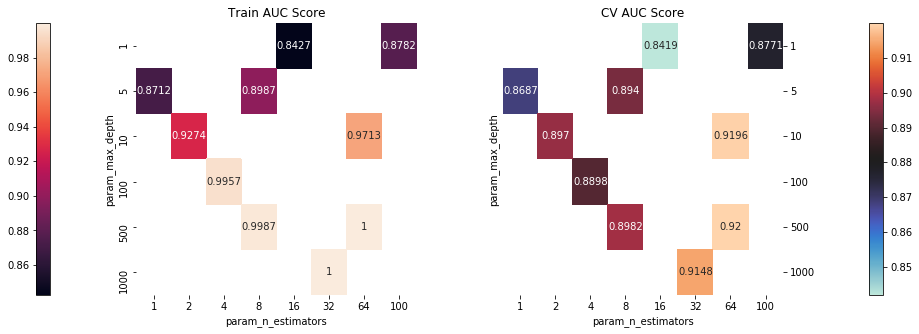

In [34]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1
# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(17,5))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket",ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire",ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False,pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

In [11]:
# Testing Accuracy on test dataset
clf = XGBClassifier( max_depth = 500, n_estimators = 64)
clf.fit(X_Train_Vec, YTrain)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_Vec, YTrain)

predict_y = sig_clf.predict_proba(X_Train_Vec)
print("The train log loss is:",log_loss(YTrain, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_Test_Vec)
print("The test log loss is:",log_loss(YTest, predict_y, labels=clf.classes_, eps=1e-15))


The train log loss is: 0.15785568399324426
The test log loss is: 0.3712772586840731


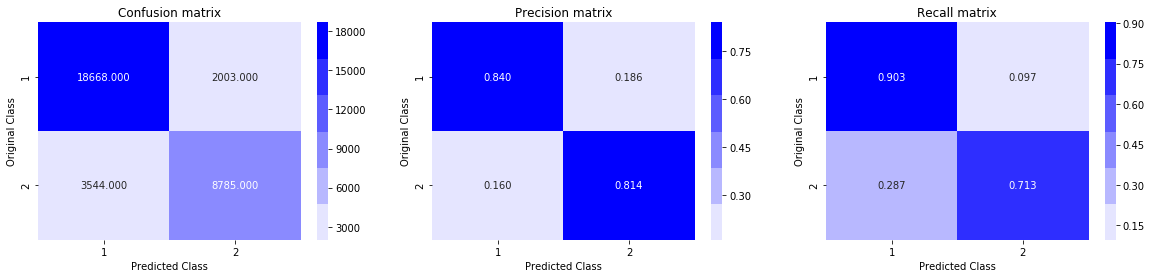

In [10]:
# print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(YTest, sig_clf.predict(X_Test_Vec))

* Observation(s):
    - Trainging and Testing log loss differ by significant amount, indicating model is overfitting.
    - Precision and Recall score for XgBoost is comparitively better than the Logistic Regression and Linear SVM model.

In [14]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "Train Log_Loss","Test Log_loss"]
x.add_row(["TFIDF", "Logistic Regression","alpha: 0.01", 0.556,0.559 ])
x.add_row(["TFIDF", "Linear SVM","alpha: 0.01" , 0.556, 0.707])
x.add_row(["TFIDF","XgBoost","n_estimator: 64\n max_depth:500",0.157,0.371 ])
print(x)

+------------+---------------------+-----------------+----------------+---------------+
| Vectorizer |        Model        |  Hyperparameter | Train Log_Loss | Test Log_loss |
+------------+---------------------+-----------------+----------------+---------------+
|   TFIDF    | Logistic Regression |   alpha: 0.01   |     0.556      |     0.559     |
|   TFIDF    |      Linear SVM     |   alpha: 0.01   |     0.556      |     0.707     |
|   TFIDF    |       XgBoost       | n_estimator: 64 |     0.157      |     0.371     |
|            |                     |   max_depth:500 |                |               |
+------------+---------------------+-----------------+----------------+---------------+
